# Chapter 5 - Compressing Data via Dimensionality Reduction
차원축소를 이용한 데이터 압축

## 1 '비지도적 데이터 압축'을 위한 차원축소
Principal component analysis(PCA) : 주성분 분석

<img src="http://4.bp.blogspot.com/-pleL0HvLUgU/UYqpNFdd8EI/AAAAAAAAAHA/uf11u9lcq5g/s1600/PCA_1.png" align="left">

In [2]:
# 주성분 분석 : '최대분산' 방향으로, 새로운 공간에 '더 작은 차원'으로 투영
# 1. 설명적 데이터 분석
# 2. 주식시장 거래의 잡음신호 처리
# 3. 유전데이터 표현수준

In [ ]:
# 분산분리 process.
# 1 d 차원 데이터를 표준화 (Standarized) 한다
# 2 공분산 행렬을 만들어, eigen_vector(고유벡터) 와 eigen_value(고유값)로 분리
# 3 가장 큰 'k' eigen_value(고유값) 에 대한 eigne_vector(고유벡터) 를 선택한다
# 4 맨 위의 'k' eigen_vector(고유벡터) 로부터 '투영행렬' W 를 만든다
# 5 새로운 feature 부분공간을 얻기위해 'W'를 사용하여, X를 변환한다

In [ ]:
# eigen : 고유한 값 (선형변환시)

### 01 Import Data
Wine 데이터 불러오기/ 70,30 나누기/ 표준화

In [3]:
import pandas as pd

df_wine = pd.read_csv('./data/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
# 훈련 데이터 70%, test 데이터 30%
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
# PCA 적용전, 데이터를 표준화 (Standarized)
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### 02 공분산 행렬을 만들고, 공분산 쌍을 지정한다
두 feature간 '공분산'을 쌍으로 계산 - 평균은 0이 된다. 
  1. '+' : feature 가 같은 방향으로 증감
  2. '-' : feature 기 다른 방향으로 증감

In [16]:
# 공분산행렬의 eigne_vector 는 PCA(주성분 분석) 을 나타내는 반면
# eigne_value의 대응값은 그들의 '규모'를 정의할 수 있다

In [15]:
# 공분산 행렬과, 공분산 행렬의 eigen_pair
import numpy as np
cov_mat = np.cov(X_train_std.T)  # np.cov() : 공분산 행렬을 계산
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) # np.linalg() : 공분산 행렬의 eigne_pair(고유값 분해)를 계산
print(cov_mat.shape, '\n\nEigenvalues  length : {}\n{}'.format(len(eigen_vals), eigen_vals ))

(13, 13) 

Eigenvalues  length : 13
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


In [18]:
# eigne_value : eigne_vector 의 크기를 정의하며, 내림차순으로 정렬
# 13개의 고유값을 비교하기 위해 '설명분산비율' 을 ploting 한다 (설명분산값의 누적합을 계산) 
# 설명분산비율 : 고유값 총합에 대한 개별 고유값의 비율
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

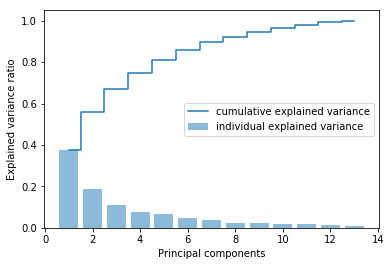

In [19]:
# 설명분산의 누적합을 시각화
import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')    # 개별 eigen_value 내림차순 정렬
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')   # 누적 합
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components'); plt.legend(loc='best'); plt.show()

In [ ]:
# 첫 feacture 가 전체분산의 40%를 차지
# 1,2 feature 합이 전체의 60%를 차지